# Two-dimensional Diffusion Equation Solver Using Finite Volume Method
## Project Demonstration
### Thursday, May 13th 2021
#### Laura Shi

In [1]:
import scipy as sc
from scipy import linalg
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint

# Set some parameters for plotting
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 16
%matplotlib inline

In [59]:
def visualize_sys(input_matrix, color, title, figSize= (8, 8)):
    plt.figure(figsize = figSize)
    plt.imshow(X = input_matrix, cmap=color, interpolation='none', origin = 'lower')
    plt.colorbar()
    plt.xticks(np.linspace(0, input_matrix.shape[0]-1, input_matrix.shape[0]))
    plt.yticks(np.linspace(0, input_matrix.shape[1]-1, input_matrix.shape[1]))
    plt.xlim([0, input_matrix.shape[0]-1])
    plt.ylim([0, input_matrix.shape[1]-1])
    plt.title(title)
    plt.show()

## Input Deck

#### Hello, welcome to the 2-d finite volume diffusion solver. Please input the size of your n x m grid:

In [60]:
# These are the number of edge points on which we will have the flux values
n = 20 #number of rows
m = 20 #number of columns

#### Boundary Condition Flags

In [61]:
leftVac = True
botVac = True
rightRef = True
topRef = True

#### Input the desired grid spacing in the x-direction (deltas) as an (m-1) vector and in the y-direction (epsilon) as an (n-1) vector:

In [62]:
# Spacing can alternate between the first value and first*spacing_alt
x_first, y_first = 1, 1
x_spacing_alt, y_spacing_alt = 1, 1 #when set to 1, all spacing is uniform

delta = np.ones(m-1)*x_first
delta[1::2] = delta[1::2]*x_spacing_alt
eps = np.ones(n-1)*y_first
eps[1::2] = eps[1::2]*y_spacing_alt

#### Specify material constants and number of divisions

In [63]:
# Create array for the cell material properties with possibility for 2 different materials:
# division defines the evenness of the split, default value is 2
# default values (right side material constants)
D_default = 10; Sigma_def = 100; Source_def = 50

#### Create arrays of material constants based on inputs above:

In [120]:
def createDividedMatrix(n, m, def_val, division = 2 , dF = 2, vert = True):
    sV = int((1/division) * n)
    output = np.ones((n-1, m-1))*def_val #coeffient grid, initialize all to default value
    if (vert):
        output[:, :sV] = output[:, :sV]*dF #left regime greater by diff fact
    else:
        output[:sV, :] = output[:sV, :]*dF
    return output
def createLineMatrix():
    return 0

def createPointMatrix(n, m, def_val): #add in functionality for center and corner
    output = np.ones((n-1, m-1))
    output[int((n-1)/2), int((m-1)/2)] = def_val
    return output

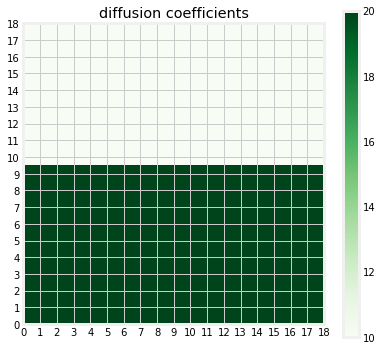

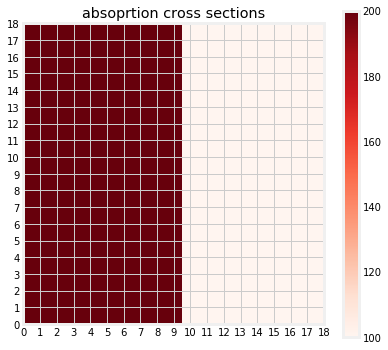

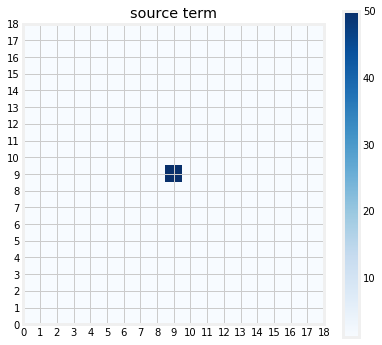

In [121]:
D = createDividedMatrix(n, m, D_default, division = 2, vert= False)
Sigma_a = createDividedMatrix(n, m, Sigma_def)
Source = createPointMatrix(n, m, Source_def)
visualize_sys(D, 'Greens', 'diffusion coefficients', figSize= (6, 6))
visualize_sys(Sigma_a, 'Reds', 'absoprtion cross sections', figSize= (6, 6))
visualize_sys(Source, 'Blues', 'source term', figSize= (6, 6))

### Averaging $\Sigma_{a, i ,j}, S_{i, j}$ to Produce $\Sigma_{a, ij}$ and $S_{ij}$

In [122]:
def make_av_matrix(orig_matrix):
    a, b = orig_matrix.shape
    n, m = a + 1, b + 1 #set values for returned array
    av_matrix = np.zeros((n, m))
    
    #corner cases, only keep 1/4th because on the corner (throws out 3 other points):
    av_matrix[0][0] = (1/4)*orig_matrix[0][0]*eps[0]*delta[0]
    av_matrix[0][m-1] = (1/4)*orig_matrix[0][m-2]*eps[0]*delta[m-2]
    av_matrix[n-1][0] = (1/4)*orig_matrix[n-2][0]*eps[n-2]*delta[0]
    av_matrix[n-1][m-1] = (1/4)*orig_matrix[n-2][m-2]*eps[n-2]*delta[m-2]
    
    #edge cases, will be half of center magnitude because throw out 2 points:
    # left edge, y = 0; right edge, y = m-2 in original
    for x in range(1, n-1):
        av_matrix[x][0] = (1/4)* (orig_matrix[x-1][0]*eps[x-1]*delta[0] + orig_matrix[x][0]*eps[x]*delta[0])
        av_matrix[x][m-1] = (1/4)* (orig_matrix[x-1][m-2]*eps[x-1]*delta[m-2] + orig_matrix[x][m-2]*eps[x]*delta[m-2])
        
    #top edge, x = 0; bottom edge, x = n-2 in original
    for y in range(1, m-1):
        av_matrix[0][y] = (1/4)* (orig_matrix[0][y-1]*eps[0]*delta[y-1] + orig_matrix[0][y]*eps[0]*delta[y])
        av_matrix[n-1][y] = (1/4)* (orig_matrix[n-2][y-1]*eps[n-2]*delta[y-1] + orig_matrix[n-2][y]*eps[n-2]*delta[y])
    
    #center cases:
    for x in range(1, (n-1)):
        for y in range(1, (m-1)):
            av_matrix[x][y] = (1/4)*(orig_matrix[x-1][y-1]*eps[x-1]*delta[y-1] + #topL
                                     orig_matrix[x][y-1]*eps[x]*delta[y-1] + #botL
                                     orig_matrix[x-1][y]*eps[x-1]*delta[y] + #topR
                                     orig_matrix[x][y]*eps[x]*delta[y]) #botR
    return av_matrix

In [123]:
#create averaged n x m arrays from above function which takes in (n-1) x (m-1) original material properties
Sigma_av = make_av_matrix(Sigma_a)
Source_av = make_av_matrix(Source)
# display(Sigma_av, Source_av)

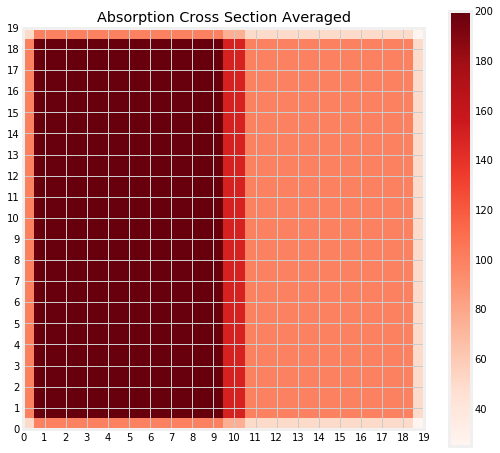

In [124]:
#visualizing the Sigma term, material properties
visualize_sys(Sigma_av, 'Reds', 'Absorption Cross Section Averaged')

## Setting Up Systems of Equations ($A$ Matrix, Source Term $\vec{S})$

\begin{equation}
\underbrace{\begin{pmatrix}
\begin{pmatrix}
a_{C}^{00} & a_{R}^{00} & 0 \\
a_{L}^{10} & a_{C}^{10} & a_{R}^{10} \\
0            & a_{L}^{20} & a_{C}^{20}
\end{pmatrix} 
&
\begin{pmatrix}
a_{T}^{00} & 0 & 0 \\
0 & a_{T}^{10} & 0 \\
0 & 0 & a_{T}^{20}
\end{pmatrix}
&
\begin{pmatrix}
 & & \\
 & \vec{0} & \\
 & & 
\end{pmatrix} \\
%--------------------
\begin{pmatrix}
a_{B}^{01} & 0 & 0 \\
0 & a_{B}^{11} & 0 \\
0 & 0 & a_{B}^{21}
\end{pmatrix}
&
\begin{pmatrix}
a_{C}^{01} & a_{R}^{01} & 0 \\
a_{L}^{11} & a_{C}^{11} & a_{R}^{11} \\
0            & a_{L}^{21} & a_{C}^{21}
\end{pmatrix}
&
\begin{pmatrix}
a_{T}^{01} & 0 & 0 \\
0 & a_{T}^{11} & 0 \\
0 & 0 & a_{T}^{21}
\end{pmatrix} \\
%--------------------
\begin{pmatrix}
 & & \\
 & \vec{0} & \\
 & & 
\end{pmatrix} &
\begin{pmatrix}
a_{B}^{02} & 0 & 0 \\
0 & a_{B}^{12} & 0 \\
0 & 0 & a_{B}^{22}
\end{pmatrix}
&
\begin{pmatrix}
a_{C}^{02} & a_{R}^{02} & 0 \\
a_{L}^{12} & a_{C}^{12} & a_{R}^{12} \\
0            & a_{L}^{22} & a_{C}^{22}
\end{pmatrix} \\
\end{pmatrix}}_{\vec{A}}
%--------------------
%
\underbrace{\begin{pmatrix} \phi_{0,0} \\ \phi_{1,0} \\ \phi_{2,0} \\ \\ \phi_{0,1} \\ \phi_{1,1} \\ \phi_{2,1} \\ \\ \phi_{0,2}\\ \phi_{1,2} \\  \phi_{2,2} \end{pmatrix}}_{\vec{\phi}} =
%
\underbrace{\begin{pmatrix} S_{00} \\ S_{10} \\ S_{20} \\ \\ S_{01} \\ S_{11} \\ S_{21} \\ \\ S_{02} \\ S_{12} \\  S_{22} \end{pmatrix}}_{\vec{S}} \nonumber
\end{equation}

Where $$S_{ij} = { S_{i,j} V_{i,j} + S_{i+1,j} V_{i+1,j} + S_{i+1,j+1} V_{i+1,j+1} + S_{i,j+1} V_{i,j+1} } $$
and
$$V_{i,j} = \frac{1}{4}\delta_i \epsilon_j \:, \quad V_{i+1,j} = \frac{1}{4}\delta_{i+1} \epsilon_{j} \:, \quad V_{i+1,j+1} = \frac{1}{4}\delta_{i+1} \epsilon_{j+1} \:, \quad V_{i,j+1} = \frac{1}{4}\delta_{i} \epsilon_{j+1} \:.$$
as previously defined above

### Creating the $A$ Matrix

In [125]:
# Definitions of left, right, bottom, top and center influence including BCs
def aL(i, j):
    if ((leftVac and i == 0) or (botVac and j == 0)):
        return 0
    if (topRef and j == m - 1): #top reflecting condition, nothing above
        return -(D[j-1][i-1]*eps[j-1])/(2*delta[i-1])
    return -(D[j-1][i-1]*eps[j-1] + D[j][i-1]*eps[j])/(2*delta[i-1])

def aR(i, j):
    if ((leftVac and i == 0) or (botVac and j == 0) or (rightRef and i == n - 1)):
        return 0
    if (topRef and j == m - 1): #top reflecting condition, nothing above
        return -(D[j-1][i]*eps[j-1])/(2*delta[i])
    return -(D[j-1][i]*eps[j-1] + D[j][i]*eps[j])/(2*delta[i])

def aB(i, j):
    if ((leftVac and i == 0) or (botVac and j == 0)):
        return 0
    if (rightRef and i == n - 1):
        return -(D[j-1][i-1]*delta[i-1])/(2*eps[j-1])
    return -(D[j-1][i-1]*delta[i-1] + D[j-1][i]*delta[i])/(2*eps[j-1])

def aT(i, j):
    if ((leftVac and i == 0) or (botVac and j == 0) or (topRef and j == m - 1)):
        return 0 #no contribution from top if have reflecting bc
    if (rightRef and i == n - 1):
        return (D[j][i-1]*delta[i-1])/(2*eps[j])
    return -(D[j][i-1]*delta[i-1] + D[j][i]*delta[i])/(2*eps[j])

def aC(i, j):
    if ((leftVac and i == 0) or (botVac and j == 0)):
        return 1
    return Sigma_av[i][j]- (aL(i, j) + aR(i, j) + aB(i, j) + aT(i, j)) 

In [126]:
#submatrix creation
#adjust to take non square matrices
def buildCenter(n, m): #right now produces a square n x n submatrix
    #n x n is dimension of individual matrix, m is the relative matrix number
    A = np.zeros((n, n)) 
    A[0, 0], A[0, 1] = aC(0, m), aR(0, m) #first line
    for j in range(1, (n-1)):
        A[j, (j-1)], A[j, j], A[j, (j+1)] = aL(j, m), aC(j, m), aR(j, m) #middle lines
    A[(n-1), (n-2)], A[(n-1), (n-1)] = aL(n-1, m), aC((n-1), m) #last line
    return A

def buildBot(n, m):
    A = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            if (i == j):
                A[i][j] = aB(j, m)
    return A

def buildTop(n, m):
    A = np.zeros((n, n))
    for i in range(0, n):
        for j in range(0, n):
            if (i == j):
                A[i][j] = aT(j, m)
    return A

In [127]:
def buildFullA(n): #assuming n is greater than or equal to 2
    A = np.zeros((n**2, n**2))
    A[0:n, 0:n], A[0:n, n:2*n] = buildCenter(n, 0), buildTop(n, 0)
    for k in range(1, (n-1)): 
        A[(k*n):(k+1)*n, (k-1)*n:(k*n)] = buildBot(n, k) #dimensions n, k is value to invoke
        A[(k*n):(k+1)*n, (k*n):(k+1)*n] = buildCenter(n, k)
        A[(k*n):(k+1)*n, (k+1)*n:(k+2)*n] = buildTop(n, k)
    A[(n-1)*n:n*n, (n-2)*n:(n-1)*n]= buildBot(n, (n-1))
    A[(n-1)*n:n*n, (n-1)*n:n*n] = buildCenter(n, (n-1))
    return A

In [128]:
A = buildFullA(n)
# A[10:20, 10:20] #sanity check as splice through the created array
A.shape 

(400, 400)

### Creating the $\vec{S}$ Source Vector

In [129]:
def reshape_source(source_in):
    n, m = source_in.shape
    # no need to flip np.flip(source_in, 0).reshape((n*m), 1) 
    # since would just end up flipping back everything, reduces complication, just use current grid
    reshaped = source_in.reshape((n*m), 1)
    return reshaped

#reshape source to be a (n x m) x 1 vector that will be our "b" to be solved
#shape the vector appropriately to account for correct indexing in a Cartesian grid (converted from array indexing)
#accounting for boundary conditions, altering the averaged source array first:
Source_av[:, 0] = 0 #all left elements have no flux b/c vacuum
Source_av[0, :] = 0 #all bottom elements have no flux b/c vacuum
Source_solve = reshape_source(Source_av)
Source_solve.shape

(400, 1)

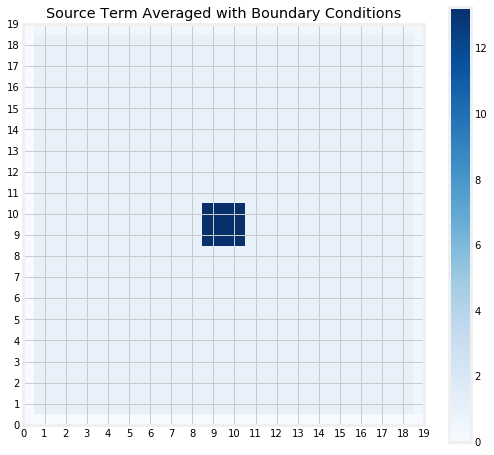

In [130]:
#visualizing the source term
visualize_sys(Source_av, 'Blues', 'Source Term Averaged with Boundary Conditions')

## Perform Iterative Methods to Solve for the Flux, $\vec{\phi}$

### Code for Iterative Methods

In [131]:
def gs(A, b, xk):
    newX = []
    n = len(b)
    for i in range(0, n):
        sum1 = 0
        sum2 = 0
        for j in range(0, n):
            if (j < i):
                sum1= sum1 + A[i][j]*newX[j]
            elif (j > i):
                sum2 = sum2 + A[i][j]*xk[j]
        
        xi = (1/(A[i][i]))* (b[i] - sum1 - sum2)
        newX.append(xi)
    return np.array(newX)

In [132]:
#general convergence checker that is general per method
def performIteration(A, b, xk, tol, method, *w):
    iter_count = 0;
    err = np.inf
    while err > tol:
        X_new = method(A, b, xk, *w)
        err = np.linalg.norm((X_new - xk)) #error is difference between previous iteration!
        iter_count = iter_count + 1
        xk = X_new
    return xk, err, iter_count

### Perform methods on the system

In [133]:
A = buildFullA(n)
b = Source_solve
x0 = np.zeros(n*n) 
tol = 10**(-6)

In [134]:
flux_sols_GS, err, count = performIteration(A, b, x0, tol, gs)
#print('solution vector GS:', flux_sols_GS)
print('iteration count:', count)
print('error:', err)

iteration count: 8
error: 4.1055818046031715e-07


### Visualizing flux $\phi$ values on a heat map

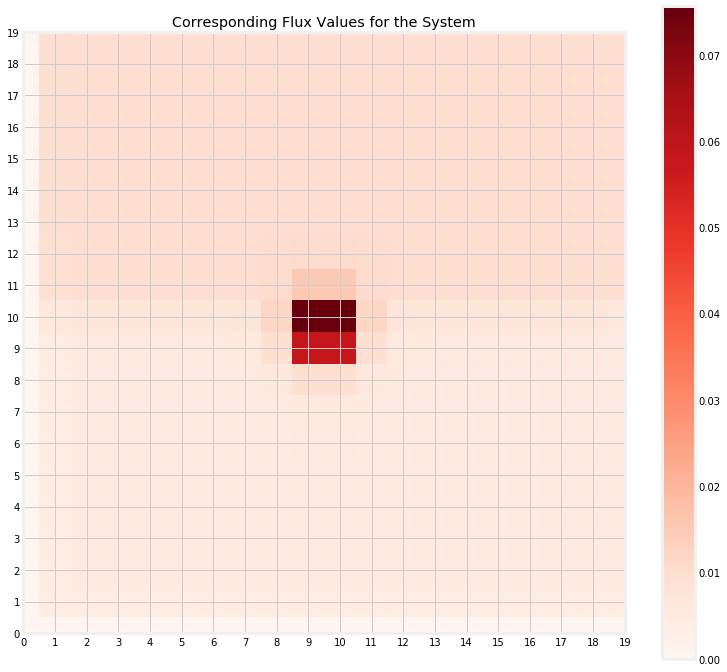

In [135]:
flux_solve = flux_sols_GS
flux_array = flux_solve.reshape(n, m)
# visualizing the flux of the system
visualize_sys(flux_array, 'Reds', 'Corresponding Flux Values for the System', (12,12))

## Sanity Check Tests with Physical Scenarios (to delete because should be able to update just it at the top and run everything and get new output)

Scenario 1: "Point" source at the center and only one material

In [55]:
point_source = np.ones((n-1, m-1))
point_source[int((n-1)/2)-2:int((n-1)/2)+2, int((m-1)/2)-2:int((m-1)/2)+2] = 3
point_source_av = make_av_matrix(point_source)

#accounting for boundary conditions, altering the averaged source array first:
point_source_av[:, 0] = 0 #all left elements have no flux b/c vacuum
point_source_av[0, :] = 0 #all bottom elements have no flux b/c vacuum

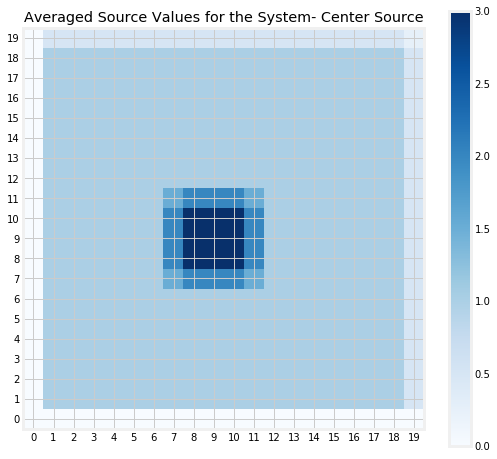

In [56]:
#visualizing the source term
visualize_sys(point_source_av, 'Blues', 'Averaged Source Values for the System- Center Source')

In [26]:
A_PS = buildFullA(n)
b_PS = reshape_source(point_source_av)
x0 = np.zeros(n*n) 
tol = 10**(-6)

flux_sols_Jacobi_PS, err, count = performIteration(A_PS, b_PS, x0, tol, jacobi)
#print('solution vector Jacobi:\n', flux_sols)
print('iteration count:', count)
print('error:', err)

iteration count: 14
error: 9.431305939384327e-07


In [27]:
flux_sols_GS_PS, err, count = performIteration(A_PS, b_PS, x0, tol, gs)
#print('solution vector GS:', flux_sols_GS)
print('iteration count:', count)
print('error:', err)

iteration count: 10
error: 4.776467626935138e-07


In [28]:
w = 1.1
flux_sols_SOR_PS, err, count = performIteration(A_PS, b_PS, x0, tol, sor, w)
#print('solution vector SOR w = 1.15:\n', flux_sols_SOR)
print('iteration count:', count)
print('error:', err)

iteration count: 8
error: 4.66529750970632e-07


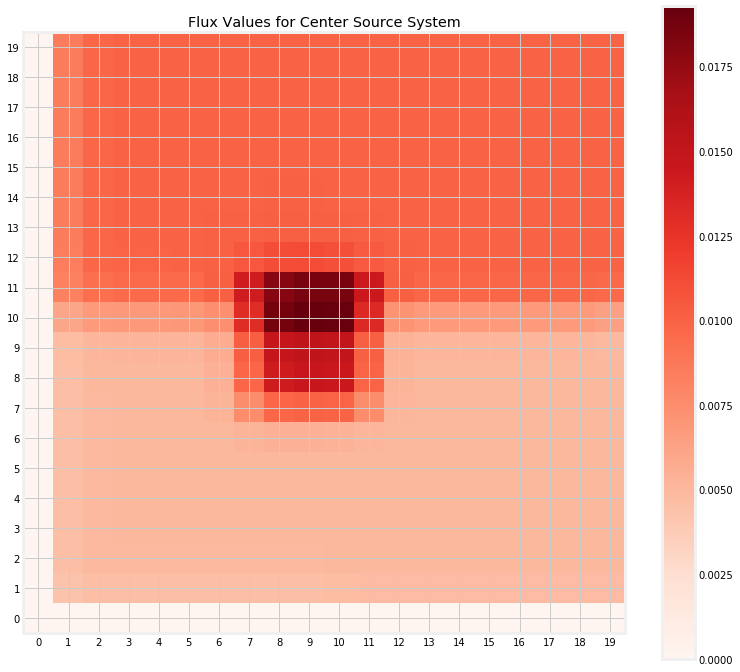

In [57]:
flux_solve_PS = flux_sols_GS_PS
flux_array_PS = flux_solve_PS.reshape(n, m)
visualize_sys(flux_array_PS, 'Reds', 'Flux Values for Center Source System', (12,12))

Scenario 2: Actual single point source in the center

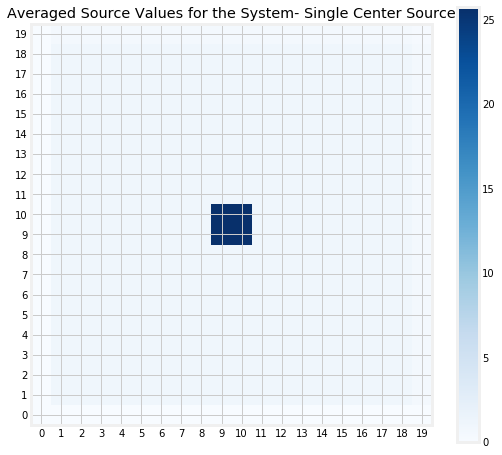

In [66]:
sing_source = np.ones((n-1, m-1))
sing_source[int((n-1)/2), int((m-1)/2)] = 100 #high magnitude such that edges basically all zero
sing_source_av = make_av_matrix(sing_source)

#accounting for boundary conditions, altering the averaged source array first:
sing_source_av[:, 0] = 0 #all left elements have no flux b/c vacuum
sing_source_av[0, :] = 0 #all bottom elements have no flux b/c vacuum
visualize_sys(sing_source_av, 'Blues', 'Averaged Source Values for the System- Single Center Source')

In [68]:
A_sing = buildFullA(n)
b_sing = reshape_source(sing_source_av)
x0 = np.zeros(n*n) 
tol = 10**(-6)

flux_sols_GS_sing, err, count = performIteration(A_sing, b_sing, x0, tol, gs)
print('iteration count:', count)
print('error:', err)

iteration count: 10
error: 4.828354953490166e-07


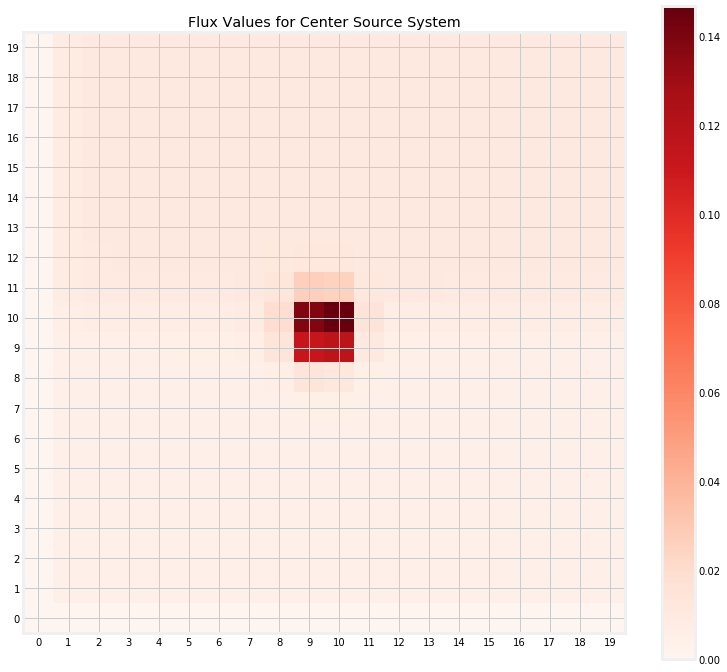

In [69]:
flux_solve_sing = flux_sols_GS_sing
flux_array_sing = flux_solve_sing.reshape(n, m)
visualize_sys(flux_array_sing, 'Reds', 'Flux Values for Center Source System', (12,12))

Scenario 3: Actual single point source in the corner of the reflecting regime

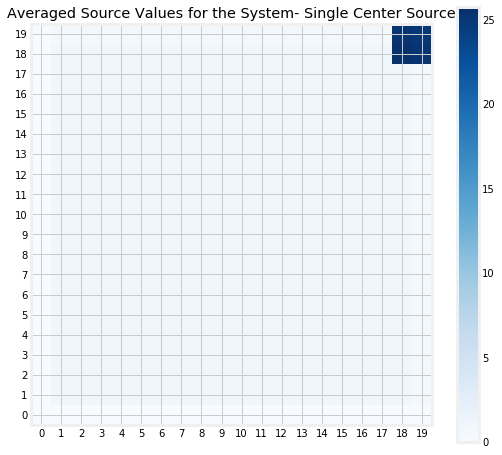

In [71]:
edge_source = np.ones((n-1, m-1))
edge_source[n-2, m-2] = 100 #high magnitude such that edges basically all zero
edge_source_av = make_av_matrix(edge_source)

#accounting for boundary conditions, altering the averaged source array first:
edge_source_av[:, 0] = 0 #all left elements have no flux b/c vacuum
edge_source_av[0, :] = 0 #all bottom elements have no flux b/c vacuum
visualize_sys(edge_source_av, 'Blues', 'Averaged Source Values for the System- Single Corner Source')

iteration count: 10
error: 4.7289994383791184e-07


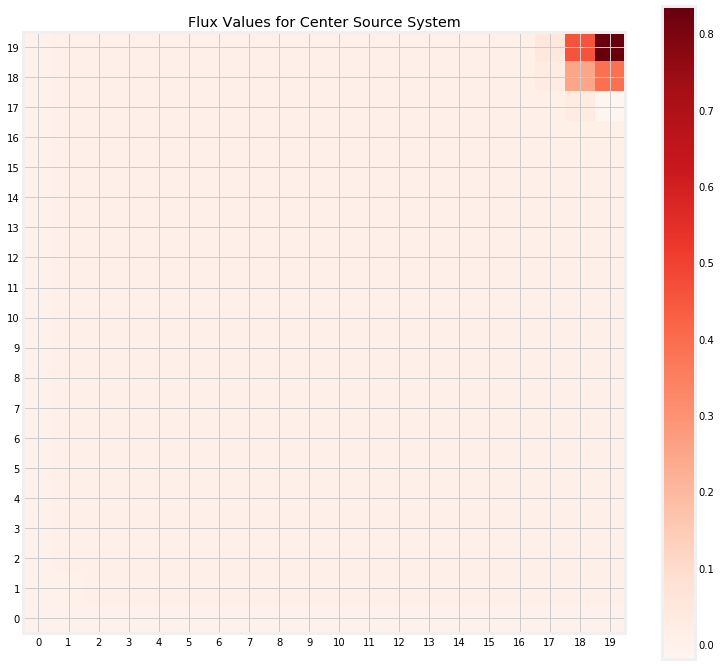

In [72]:
A_edge = buildFullA(n)
b_edge = reshape_source(edge_source_av)
x0 = np.zeros(n*n) 
tol = 10**(-6)

flux_sols_GS_edge, err, count = performIteration(A_edge, b_edge, x0, tol, gs)
print('iteration count:', count)
print('error:', err)

flux_solve_edge = flux_sols_GS_edge
flux_array_edge = flux_solve_edge.reshape(n, m)
visualize_sys(flux_array_edge, 'Reds', 'Flux Values for Center Source System', (12,12))

Scenario 4: Line Source Across Material Divide

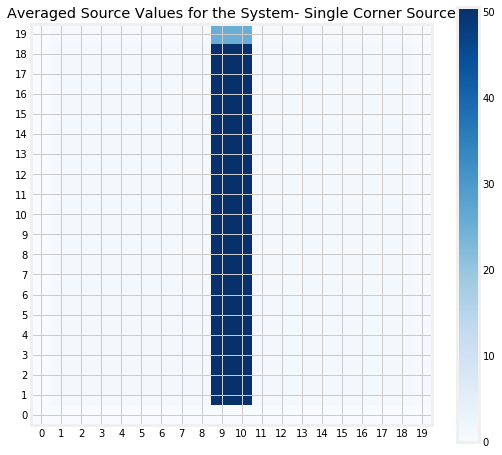

In [74]:
line_source = np.ones((n-1, m-1))
line_source[:, int((m-1)/2)] = 100 #high magnitude such that edges basically all zero
line_source_av = make_av_matrix(line_source)

#accounting for boundary conditions, altering the averaged source array first:
line_source_av[:, 0] = 0 #all left elements have no flux b/c vacuum
line_source_av[0, :] = 0 #all bottom elements have no flux b/c vacuum
visualize_sys(line_source_av, 'Blues', 'Averaged Source Values for the System- Single Corner Source')

iteration count: 12
error: 5.198310234954908e-07


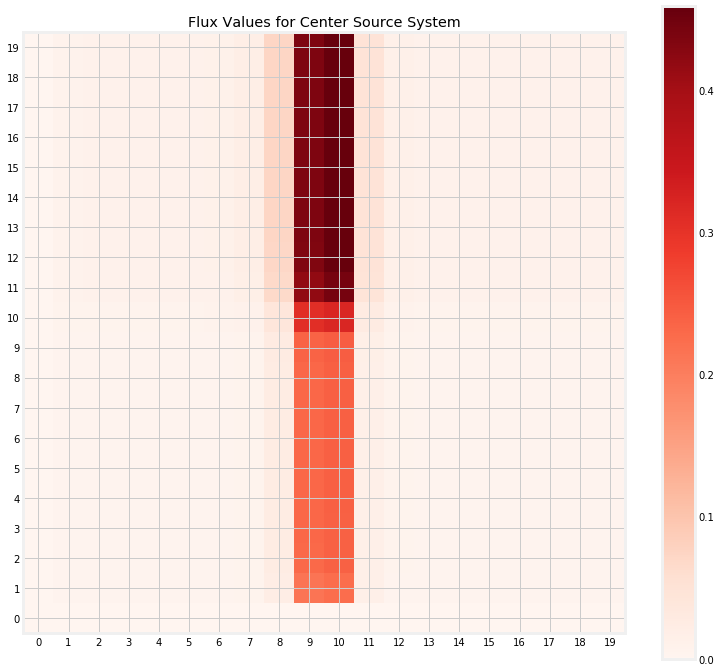

In [75]:
A_line = buildFullA(n)
b_line = reshape_source(line_source_av)
x0 = np.zeros(n*n) 
tol = 10**(-6)

flux_sols_GS_line, err, count = performIteration(A_line, b_line, x0, tol, gs)
print('iteration count:', count)
print('error:', err)

flux_solve_line = flux_sols_GS_line
flux_array_line = flux_solve_line.reshape(n, m)
visualize_sys(flux_array_line, 'Reds', 'Flux Values for Center Source System', (12,12))